# Hyperbolic Multidimensional Scaling
`Drew Wilimitis`

In this notebook, I go over some of the background and theoretical groundwork behind my attempt to implement a Multidimensional Scaling (MDS) algorithm that embeds data into hyperbolic space instead of the target Euclidean space. Just like traditional MDS, h-MDS (hyperbolic MDS) seeks to produce accurate spatial representations of possibly high dimensional datasets, by  attempting to reflect the original pairwise similarities by the corresponding pairwise distances in the embedding space. <br>
<br>
Papers that discuss some of the relevant theory underlying hyperbolic MDS and outline some general implementation details are the following are given below, but the theoretical background discussed below is essentially from **[1]**.

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

## Poincaré Disk and Hyperbolic Lines

We use the Poincaré disk as our model of hyperbolic space, and the only fundamental change with respect to MDS in Euclidean space is that we need to use the Poincaré distance metric instead of the Euclidean distance.

We can define the Poincare disk based on the complex plane: $\mathbb{D}=\{z \in \mathbb{C}| | z |<1\}$ <br>
<br>
$$
d_{\mathbb{D}}\left(z_{j}, z_{k}\right)=2 \operatorname{atanh} \frac{\left|z_{j}-z_{k}\right|}{\left|1-z_{j} \overline{z}_{k}\right|}
$$

The idea of Mobius transformations will also be important, and these are transformations that preserve hyperbolic distances. The Mobius transformations $T$ have the following form: <br> 
<br>
$$
T(z)=\frac{a z+b}{\overline{b} z+\overline{a}}, a, b \in \mathbb{C},|a|^{2}-|b|^{2} \neq 0
$$

alternatively we can write this as: <br>
$$
z^{\prime}=T(z ; c, \theta)=\frac{\theta z+c}{\overline{c} \theta z+1}, \quad|\theta|=1,|c|<1
$$

Our h-MDS algorithm will have a relatively simple design based on iterative steepest descent and an approximate line search function. Therefore, we need to be able to describe hyperbolic lines based on a given direction $\gamma$ and a starting point $z_0$. For $z_{0} \in \mathbb{D}, \gamma \in \mathbb{C}$ with $|\gamma|=1,$ and $s \geq 0$, this hyperbolic line is given by:<br>
<br>
$$
z_{0}^{\prime}=\frac{\gamma \tanh \frac{s}{2}+z_{0}}{\overline{z_{0}} \gamma \tanh \frac{s}{2}+1}
$$ <br>
where $s$ gives the length along the line and $d_{\mathrm{D}}\left(z_{0}, z_{0}^{\prime}\right)=s$ <br>
<br>
Here we explore plotting hyperbolic lines in the poincare disk.

In [28]:
# define helper functions
def norm(x, axis=None):
    return np.linalg.norm(x, axis=axis)

# convert array or list [a, b] to complex number a+bi
def to_complex(xi):
    return np.complex(xi[0], xi[1])
to_complex([1,1])
np.complex(1+1j)*np.complex(1-1j)
np.conj(1+1j)
np.complex(1,1)
norm(np.complex(0.7,0.7))

(1+1j)

(2+0j)

(1-1j)

(1+1j)

0.9899494936611665

In [6]:
# parametrized hyperbolic line with distance s from point z0 in direction gamma
def hyp_line(s, gamma, z0):
    if not isinstance(z0,complex):
        z0 = to_complex(z0)
    if not isinstance(gamma, complex):
        gamma = to_complex(gamma)
    return (gamma * np.tanh(s/2) + z0) / (np.conj(z0) * gamma * np.tanh(s/2) + 1)

def plot_hyp_line(dist, gamma, z0, whole_line = False, z0_label=None, endpts = False):
    ax = plt.gca()
    if np.all(gamma == 0):
        ax.scatter(np.real(z0), np.imag(z0), s=40, alpha=1, c='black');
        ax.text(np.real(z0)-0.05, np.imag(z0)+0.05, z0_label, size=16);
        return
    gamma = gamma / norm(gamma)
    pts = []
    for r in np.arange(0, dist, 0.1):
        zj = hyp_line(r, gamma, z0)
        pts.append(zj)
        if whole_line:
            zj_flip = hyp_line(r, -1*gamma, z0)
            pts.append(zj_flip)
    pts = np.array(pts)
    ax.scatter(np.real(pts), np.imag(pts), s=10, alpha=1)
    ax.scatter(np.real(z0), np.imag(z0), s=40, alpha=1, c='black')
    ax.text(np.real(z0)-0.05, np.imag(z0)+0.05, z0_label, size=16);
    if endpts:
        z0_prime = pts[-1]
        ax.scatter(np.real(z0_prime), np.imag(z0_prime), s=40, alpha=1)
        ax.text(np.real(z0_prime)-0.1, np.imag(z0_prime)+0.05, "Zo'", size=14)

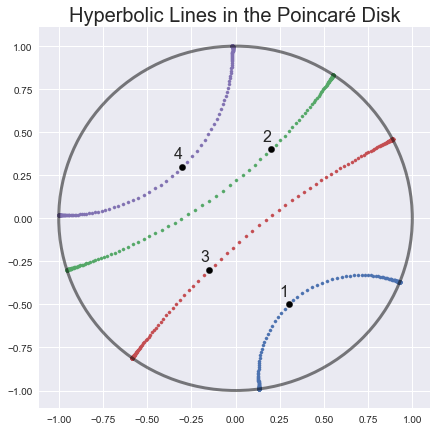

In [10]:
# plot sample hyperbolic lines
fig = plt.figure(figsize=(7,7))
plt.style.use('seaborn')
ax = fig.add_subplot(111)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
y = np.complex(1,1)
Z = np.array([np.complex(0.3,-0.5), np.complex(0.2,0.4), np.complex(-0.15,-0.3), np.complex(-0.3,0.3)])
for i, z0 in enumerate(Z):
    plot_hyp_line(10, y, z0, z0_label=str(i+1), whole_line=True);
plt.title('Hyperbolic Lines in the Poincaré Disk', size=20);

# Loss Function and Gradients

For the initial implementation of h-MDS let the error function be given by the Absolute Differences Squared (ADS) <br>
<br>
$$
E=\sum_{j=1}^{n} \sum_{k=j+1}^{n} w_{j k}\left(I_{j k}\left(d_{j k}-a \delta_{j k}\right)\right)^{2}
$$ <br>
$W$ is a weight matrix and $I$ is an indicator matrix for sparse/missing values in dissimilarity matrix <br>
$d_{j k}$ is the distance in the poincaré disk and $\delta_{j k}$ is the original dissimilarity <br>
<br>
Hyperbolic distance is not scale invariant like Euclidean distance, so we have an additional degree of freedom $\alpha$ - a scaling factor for the original entries of dissimilarity matrix

We need to find the gradient of the error function $E$ <br>
<br>
$$
\nabla E \stackrel{\mathrm{def}}{=}\left[\begin{array}{c}{\frac{\partial E}{\partial y_{1,1}}+i \frac{\partial E}{\partial y_{1,2}}} \\ {\frac{\partial E}{\partial y_{2,1}}+i \frac{\partial E}{\partial y_{2,2}}} \\ {\vdots} \\ {\frac{\partial E}{\partial y_{n, 1}}+i \frac{\partial E}{\partial y_{n, 2}}}\end{array}\right]
$$ <br>
<br>
Using the chain rule: <br>
$$
\nabla E=\frac{\partial E (z_i)}{\partial d(z_i, z_j)} \frac{\partial d(z_i, z_j)}{\partial z_i}
$$

The first partial derivative term for the loss function is given by:<br>
<br>
$$\frac{\partial E (z_i)}{\partial d(z_i, z_j)} = w_{i j} (2 d(z_i, z_j) - 2 \alpha \delta_{i j})$$

For the partial derivatives of the poincare distance, we have: <br>
<br>
$$
\begin{aligned} \frac{\partial}{\partial x_{i, 1}} d\left(\mathbf{x}_{i}, \mathbf{x}_{j}\right) &=\frac{2 t}{1-t^{2}}\left(\frac{v_{1}}{v_{1}^{2}+v_{2}^{2}}-\frac{x_{j, 1} v_{3}+x_{j, 2} v_{4}}{v_{3}^{2}+v_{4}^{2}}\right) \\ \frac{\partial}{\partial x_{i, 2}} d\left(\mathbf{x}_{i}, \mathbf{x}_{j}\right) &=\frac{2 t}{1-t^{2}}\left(\frac{v_{2}}{v_{1}^{2}+v_{2}^{2}}+\frac{x_{i, 1} v_{4}-x_{j, 2} v_{3}}{v_{3}^{2}+v_{4}^{2}}\right) \end{aligned}
$$

with the following definitions of these terms: <br>

$$
\begin{aligned} \mathbf{x}_{i} &=\left(x_{i, 1}+\mathrm{i} x_{i, 2}\right) \in P D \subset \mathbb{C} \\ \mathbf{x}_{j} &=\left(x_{j, 1}+\mathrm{i} x_{j, 2}\right) \in P D \subset \mathbb{C} \\ v_{1} &=x_{i, 1}-x_{j, 1} \\ v_{3} &=x_{i, 1} x_{j, 1}+x_{i, 2} x_{j, 2}-1 \\ v_{2} &=x_{i, 2}-x_{j, 2} \\ v_{4} &=x_{i, 1} x_{j, 2}-x_{j, 1} x_{i, 2} \\ t^{2} &=\frac{v_{1}^{2}+v_{2}^{2}}{v_{3}^{2}+v_{4}^{2}} \end{aligned}
$$

and finally we have an explicit form of the gradient $\nabla E$

## Steepest Descent Direction

The descent direction is defined by the gradient of this error function: <br>
<br>
$$
\mathbf{g}=\nabla E \stackrel{\mathrm{def}}{=}\left[\begin{array}{c}{\frac{\partial E}{\partial y_{1,1}}+i \frac{\partial E}{\partial y_{1,2}}} \\ {\frac{\partial E}{\partial y_{2,1}}+i \frac{\partial E}{\partial y_{2,2}}} \\ {\vdots} \\ {\frac{\partial E}{\partial y_{n, 1}}+i \frac{\partial E}{\partial y_{n, 2}}}\end{array}\right]=\left[\begin{array}{c}{g_{1}} \\ {g_{2}} \\ {\vdots} \\ {g_{n}}\end{array}\right]
$$<br>
We have descent directions $-g_1, \ldots , -g_n$ and the new configuration after the update will have points <br>
<br>
$$
z_{j}^{\prime}=\frac{-r g_{j}+z_{j}}{-r g_{j} \overline{z_{j}}+1}
$$ <br>
and $r \geq 0$ is the step-size parameter

We now visualize gradient descent in the hyperbolic space and explore the error along these steepest descent directions. 

In [29]:
# poincare distance formula with complex numbers
def poincare_dist(zi, zj):
    if not isinstance(zi,complex):
        zi = to_complex(zi)
    if not isinstance(zj,complex):
        zj = to_complex(zj)
    return 2*np.arctanh(norm(zi - zj) / norm(1 - zi*np.conj(zj)))

# compute symmetric poincare distance matrix
def pd_matrix(embedding):
    n = embedding.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist_matrix[i][j] = poincare_dist(embedding[i], embedding[j])
    return dist_matrix

# partial derivative of poincare distance
def partial_d(xi, xj):
    if not isinstance(xi,complex):
        xi = to_complex(xi)
    if not isinstance(xj,complex):
        xj = to_complex(xj)
    v1 = np.real(xi) - np.real(xj)
    v2 = np.imag(xi) - np.imag(xj)
    v3 = np.real(xi)*np.real(xj) + np.imag(xi)*np.imag(xj) - 1
    v4 = np.real(xi)*np.imag(xj) - np.real(xj)*np.imag(xi)
    t = np.sqrt((v1**2 + v2**2) / (v3**2 + v4**2))
    dxi_1 = 2*t / (1 - t**2) * (v1 / (v1**2 + v2**2) - (np.real(xj)*v3 + np.imag(xj)*v4) / (v3**2 + v4**2))
    dxi_2 = 2*t / (1 - t**2) * (v2 / (v1**2 + v2**2) - (np.real(xi)*v4 - np.imag(xj)*v3) / (v3**2 + v4**2))
    return np.array([dxi_1, dxi_2])

In [14]:
# compute gradients from embedding and input dissimilarity
def compute_gradients(Z, dissimilarities, alpha=1):
    n = Z.shape[0]
    gradients = np.zeros((n, 2))
    for i in range(n):
        grad_zi = 0
        for j in range(i+1, n):
            dd_loss = 2*poincare_dist(Z[i], Z[j]) - 2*alpha*dissimilarities[i][j]
            dd_dist = partial_d(Z[i], Z[j])
            grad_zi += dd_loss * dd_dist
        if norm(grad_zi) > 1:
            grad_zi = grad_zi / norm(grad_zi)
        gradients[i] = grad_zi
    return gradients

# evaluate embedding error
def loss_fn(embed_config, dissimilarities, alpha=1):
    n = dissimilarities.shape[0]
    loss = 0
    for i in range(n):
        for j in range(i+1, n):
            zi_error = (poincare_dist(embed_config[i], embed_config[j]) - alpha*dissimilarities[i][j])**2
            loss += zi_error
    return loss

In [30]:
# generate random data sample
def generate_data(n, radius=0.3):
    theta = np.random.uniform(0, 2*np.pi, n)
    u = np.random.uniform(0, radius, n)
    r = np.sqrt(u)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    init_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
    return init_data

# initialize the embedding configuration
def init_z(n, dim=2, low=-0.5, high=0.5, complex_num = True):
    random_config = np.random.uniform(low, high, size=(n, dim))
    z_config = np.array([to_complex(x) for x in random_config])
    if complex_num:
        return z_config
    else:
        return random_config

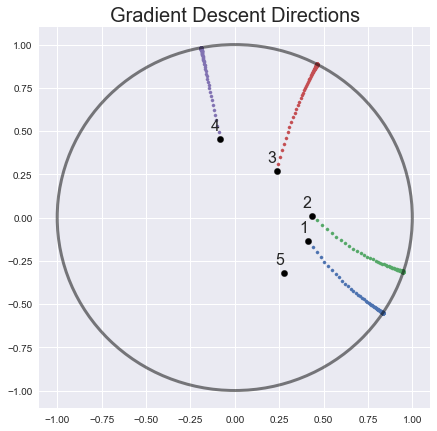

In [32]:
# plot gradient descent lines in hyperbolic space
data = generate_data(5)
delta = euclidean_distances(data)
init_config = init_z(delta.shape[0], complex_num=False)
z_config = np.array([to_complex(x) for x in init_config], dtype=np.complex_)
init_g = compute_gradients(init_config, delta)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
for i, z0 in enumerate(z_config):
    plot_hyp_line(10, init_g[i], z0, z0_label=str(i+1));
plt.title('Gradient Descent Directions', size=20);

## Approximate Hyperbolic Line Search

We have some more notation and parameters related to line search. $s_M$ sets the window for distance between successive configurations or updates. We need this to be finite to limit points from approaching the boundary at infinite distances. If $s_j$ are distances for updates: $s_{M}=\max _{j} s_{j}<\infty$<br>
<br>
The parameter $r_M$ sets the window for the step size $r$ and we restrict our line search for each update within this window. We have the constraint: $r<\frac{1}{\|\mathbf{g}\|_{\infty}}$ and the following equation that relates these parameters: <br>

$$
r_{M}=\frac{1}{\|\mathbf{g}\|_{\infty}} \cdot \tanh \frac{s_{M}}{2}<\frac{1}{\|\mathbf{g}\|_{\infty}}
$$

During our line search, it would be ideal to find the step size $r$ along the hyperbolic line (but within the window $r_M$) that minimizes the error function. This turns out to be too computationally expensive, and so we just set a sufficient stopping condition and accept any step size that meets the condition. 

To express the stopping condition, we define the error in terms of the step size and let this function be $q(r)$ <br>
<br>
We also define this 'roof' function: $\lambda(r)=q(0)+p \cdot q^{\prime}(0) \cdot r, \quad 0<p<1$ <br>
<br>
and set the condition for acceptable values of step size: $q(r)<\lambda(r), r \in\left(0, r_{M}\right]$ 

![title](images/line_search.png) <br>
source: A. Cvetkovski and M. Crovella. Multidimensional scaling in the Poincaré disk

We need to find explicit formulas for $q(r)$ and its derivative $q'(r)$ in order to calculate these values and apply the stopping conditions in the approximate line search. <br>
<br>
We can write the updates for each $z_j$ based on the Mobius transformations: $M_{j}(r)=\frac{-r g_{j}+z_{j}}{-r g_{j} \overline{z}_{j}+1}$

The expression for the error in terms of step size can now be written as $q(r)=E(\mathbf{M}(-r \mathbf{g}, \mathbf{z}), \mathbf{\Delta}, \mathbf{W}, \mathbf{I})$ <br>
<br>
$q'(r)$ has the following form: <br>
<br>
$$
\begin{aligned} q^{\prime}(r) &=\frac{d}{d r} q(r)=\\ &=\left(\operatorname{Re} \mathbf{M}^{\prime}(-r \mathbf{g}, \mathbf{z})\right)^{T} \operatorname{Re} \nabla E(\mathbf{M}(-r \mathbf{g}, \mathbf{z}), \boldsymbol{\Delta}, \mathbf{W}, \mathbf{I}) \\ &+\left(\operatorname{Im} \mathbf{M}^{\prime}(-r \mathbf{g}, \mathbf{z})\right)^{T} \operatorname{Im} \nabla E(\mathbf{M}(-r \mathbf{g}, \mathbf{z}), \boldsymbol{\Delta}, \mathbf{W}, \mathbf{I}) \end{aligned}
$$

and this can be explicitly calculated using the following equation: <br>
<br>
$$
M_{j}^{\prime}(r)=\frac{d}{d r} M_{j}(r)=g_{j} \frac{\left|z_{j}\right|^{2}-1}{\left(1-r g_{j} \overline{z_{j}}\right)^{2}}
$$

Below I define functions for the step error along the gradient descent directions and visualize the loss curve at various step sizes along the descent direction.

In [77]:
def step_error(r, Z, g, dissimilarities, n=None):
    if n == None:
        n = dissimilarities.shape[0]
    if not isinstance(Z[0], complex):
        Z = np.array([to_complex(zi) for zi in Z])
    if not isinstance(g[0], complex):
        g = np.array([to_complex(gi) for gi in g])
    M_r = []
    for j in range(n):
        M_r.append((-r*g[j] + Z[j]) / (-r*g[j] * np.conj(Z[j]) + 1))
    return loss_fn(np.array(M_r), dissimilarities)

def plot_step_error(delta):
    init_config = init_z(delta.shape[0], complex_num=False)
    z_config = np.array([to_complex(x) for x in init_config])
    init_g = compute_gradients(init_config, delta)
    init_loss = loss_fn(init_config, delta)
    errors = []
    step_range = np.arange(0, 1, 0.02)
    for step_size in step_range:
        errors.append(step_error(step_size, z_config, init_g, delta))
    plt.scatter(step_range, np.array(errors))
    plt.xlabel('Step size r', size=14)
    plt.ylabel('Loss', size=14)
    plt.title('Loss Function vs. Step Size', size=18)
    print('Initial loss: ', init_loss)
    print('min step error = ', np.min(errors))
    print('step size = ', step_range[errors.index(np.min(errors))]);

First we look at the loss along descent directions for a random data sample with input dissimilarities.  

Initial loss:  53.98819159414136
min step error =  17.634416424066842
step size =  0.4


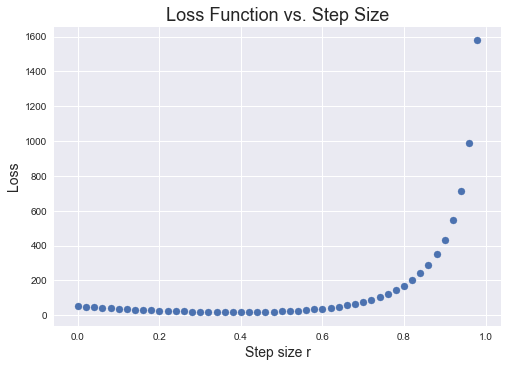

In [78]:
# random data sample
tmp_data = generate_data(10)
tmp_pdelta = pd_matrix(tmp_data)
tmp_delta = euclidean_distances(tmp_data)
plot_step_error(tmp_delta)

Now we do the same for a small dataset with animal classes and feature attributes.

In [43]:
# animals dataset from UCI ML repository
zoo = pd.read_csv('zoo.data', header=None)
animals = ['hare', 'goat', 'octopus', 'wolf', 'chicken', 'tuna', 'lobster', 'cheetah', 
           'dove', 'opossum', 'raccoon', 'crow', 'sparrow']
animals_data = zoo.loc[zoo[0].apply(lambda x: x in animals), ]
animals_name = animals_data[0]
animals_data = animals_data.loc[:, 1:]
animals_name = np.array(animals_name)
zoo.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


Initial loss:  1127.3118119405244
min step error =  556.0504916610548
step size =  0.72


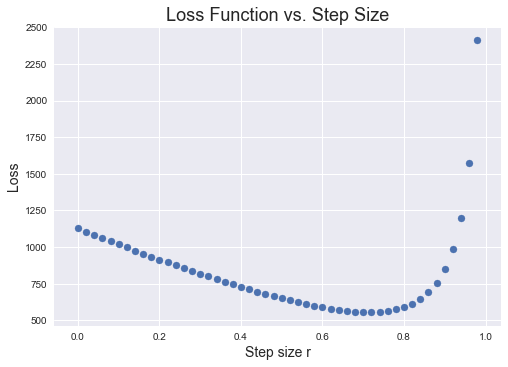

In [79]:
dissimilarity_matrix = euclidean_distances(animals_data)
plot_step_error(dissimilarity_matrix)

Finally we view a plot for the iris dataset.

Initial loss:  53637.133197496485
min step error =  38112.387454170326
step size =  0.56


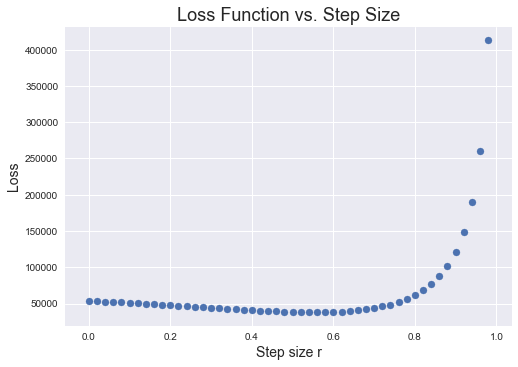

In [80]:
from sklearn.datasets import load_iris
iris = load_iris()
iris_data = iris.data
plot_step_error(euclidean_distances(iris_data))

We now compare these optimal values from this nearly exact line search with our approximate line search method based on binary search and only guaranteeing sufficient decrease.

In [81]:
def plot_line_search(Z, dissimilarities, g, n, r0, rmax):
    if not isinstance(Z[0], complex):
        Z = np.array([to_complex(zi) for zi in Z])
    if not isinstance(g[0], complex):
        g = np.array([to_complex(gi) for gi in g])
    Z_norm = np.array([norm(z)**2 for z in Z])
    M_prime = g*Z_norm
    qprime_0 = np.dot(np.real(M_prime).T, np.real(g)) + np.dot(np.imag(M_prime).T, np.imag(g))
    p = 0.5
    r = r0
    q0 = step_error(0, Z, g, dissimilarities, n)
    roof_fn = lambda r: q0 + p*qprime_0*r
    rmin = 1e-10
    step_errors = []
    step_sizes = []
    roof_vals = []
    while r < rmax and step_error(r, Z, g, dissimilarities, n) < roof_fn(r):
        step_sizes.append(r)
        roof_vals.append(roof_fn(r))
        step_errors.append(step_error(r, Z, g, dissimilarities, n))
        r = 2*r
    while r > rmax or step_error(r, Z, g, dissimilarities, n) > roof_fn(r):
        step_sizes.append(r)
        roof_vals.append(roof_fn(r))
        step_errors.append(step_error(r, Z, g, dissimilarities, n))
        if r < rmin:
            return 2*r
        r = r/2
    final_r = r
    final_error = step_error(r, Z, g, dissimilarities, n)
    plt.scatter(np.array(step_sizes), np.array(step_errors), c='red')
    plt.scatter(np.array(step_sizes), np.array(roof_vals), c='black')
    plt.text(final_r + 0.01, final_error + 0.02, s = 'r*', size=16)
    plt.xlabel('Step size r', size=14)
    plt.ylabel('Loss', size=14)
    plt.title('Approx. Line Search', size=20)
    plt.show()
    print('Inital Loss: ', loss_fn(Z, dissimilarities))
    print('Approx. line search:')
    print('Loss(r*) = ', final_error)
    print('r* = ', final_r);

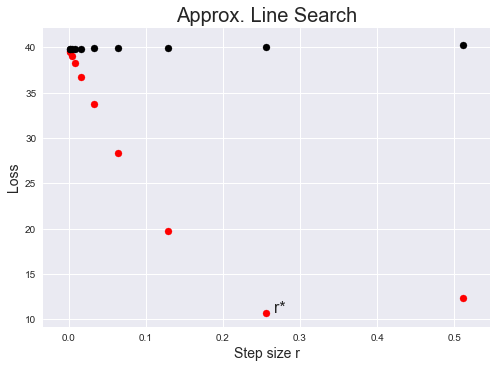

Inital Loss:  39.8468527628426
Approx. line search:
Loss(r*) =  10.69427283350209
r* =  0.256


In [82]:
plot_line_search(z_config, delta, init_g, delta.shape[0], 0.001, 0.5)

Viewing them side by side we compare how close our approximation is to an optimal minimum

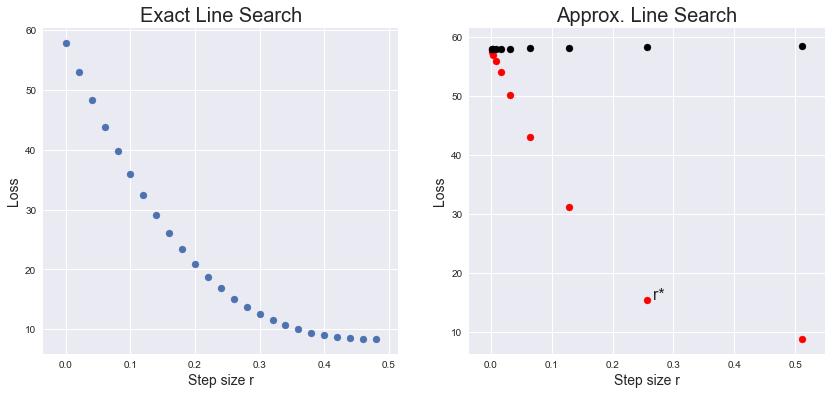

Inital Loss:  57.975355193247196
Approx. line search:
Loss(r*) =  15.440595294236982
r* =  0.256

Exact Line Search:
Min loss =  8.378135593059893
Step size =  0.46


In [83]:
data = generate_data(10)
delta = euclidean_distances(data)
init_config = init_z(delta.shape[0], complex_num=False)
z_config = np.array([to_complex(x) for x in init_config])
init_g = compute_gradients(init_config, delta)
init_loss = loss_fn(init_config, delta)
errors = []
step_range = np.arange(0, 0.5, 0.02)
for step_size in step_range:
    errors.append(step_error(step_size, z_config, init_g, delta))
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(step_range, np.array(errors))
plt.xlabel('Step size r', size=14)
plt.ylabel('Loss', size=14)
plt.title('Exact Line Search', size=20)

plt.subplot(1, 2, 2)
plot_line_search(z_config, delta, init_g, delta.shape[0], 0.001, 0.5)
print('\nExact Line Search:')
print('Min loss = ', np.min(errors))
print('Step size = ', step_range[errors.index(np.min(errors))]);

Finally, since different inputs will have much different loss curves, it's possible for the approximate line search to perform significantly better or worse on different inputs.

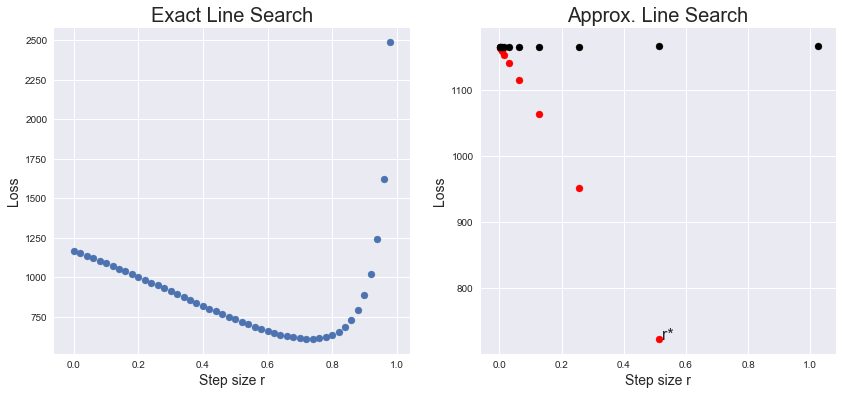

Inital Loss:  1165.2584283673482
Approx. line search:
Loss(r*) =  723.2217476834068
r* =  0.512

Exact Line Search:
Min loss =  608.2935561308847
Step size =  0.74


In [90]:
# compare line search for animals data
delta = euclidean_distances(animals_data)
init_config = init_z(delta.shape[0], complex_num=False)
z_config = np.array([to_complex(x) for x in init_config])
init_g = compute_gradients(init_config, delta)
init_loss = loss_fn(init_config, delta)
errors = []
step_range = np.arange(0, 1, 0.02)
for step_size in step_range:
    errors.append(step_error(step_size, z_config, init_g, delta))
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(step_range, np.array(errors))
plt.xlabel('Step size r', size=14)
plt.ylabel('Loss', size=14)
plt.title('Exact Line Search', size=20)

plt.subplot(1, 2, 2)
plot_line_search(z_config, delta, init_g, delta.shape[0], 0.001, 1)
print('\nExact Line Search:')
print('Min loss = ', np.min(errors))
print('Step size = ', step_range[errors.index(np.min(errors))]);

This essentially covers the core concepts behind MDS in the Poincaré disk, namely defining an appropriate loss function, adapting a gradient descent method to hyperbolic space, and using an approximate line search in the optimization routine. In the full implementation, I attempt to also reproduce comparable evaluation results and work through some additional implementation details. 

In [2]:
from IPython.core.display import HTML

def css_styling():
    styles = open("custom_style.css", "r").read()
    return HTML(styles)
css_styling()

## References
---

[1]. A. Cvetkovski and M. Crovella. Multidimensional scaling in the Poincaré disk. arXiv:1105.5332, 2011.<br>
[2]. H-MDS: a new approach for interactive visualization with multidimensional scaling in the hyperbolic space. Jörg Walter. Information Systems, Elsevier, 29(4):273-292, 2004.<br>
[3] De Sa, C., Gu, A., Ré, C., and Sala, F. Representation tradeoffs for hyperbolic embeddings. arXiv preprint arXiv:1804.03329, 2018.